In [14]:
from urllib.request import urlopen
import re

import pandas as pd
from bs4 import BeautifulSoup
import requests
from langchain_text_splitters import RecursiveCharacterTextSplitter
from datasets import Dataset

In [15]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    model_name="gpt-2", chunk_size=300, chunk_overlap=100
)

In [16]:
headers = {'User-Agent': 'RuhiBot/0.0 (r.u.mahadeshwar@rug.nl)'}

In [25]:
path = 'datasets_all/wikipedia-subset'

In [18]:
urls = {
        # Kingdom of Holland
        "kingdom_holland": 
            {
                'en':'https://en.wikipedia.org/wiki/Kingdom_of_Holland',
                'fr':'https://fr.wikipedia.org/wiki/Royaume_de_Hollande',
                'nl':'https://nl.wikipedia.org/wiki/Koninkrijk_Holland'
            },
    
        # Napoleonic Wars
        "napoleonic_wars":
            {
                'en':'https://en.wikipedia.org/wiki/Napoleonic_Wars',
                'fr':'https://fr.wikipedia.org/wiki/Guerres_napol%C3%A9oniennes',
                'nl':'https://nl.wikipedia.org/wiki/Franse_revolutionaire_en_napoleontische_oorlogen',
            },
    
        # Battle of Waterloo
        "waterloo_battle":
            {
                'en':'https://en.wikipedia.org/wiki/Battle_of_Waterloo',
                'fr':'https://fr.wikipedia.org/wiki/Bataille_de_Waterloo',
                'nl':'https://nl.wikipedia.org/wiki/Slag_bij_Waterloo',
            },     
        
        # French invasion of Russia
        "french_invasion_russia":
            {
                'en':'https://en.wikipedia.org/wiki/French_invasion_of_Russia',
                'fr':'https://fr.wikipedia.org/wiki/Campagne_de_Russie',
                'nl':'https://nl.wikipedia.org/wiki/Veldtocht_van_Napoleon_naar_Rusland',
            },    
        
        # Louis Bonaparte
        "king_louis_bonaparte":
            {
                'en':'https://en.wikipedia.org/wiki/Louis_Bonaparte',
                'fr':'https://fr.wikipedia.org/wiki/Louis_Bonaparte',
                'nl':'https://nl.wikipedia.org/wiki/Lodewijk_Napoleon',
            },
        
        # Napoleon
        "king_napoleon_bonaparte":
            {
                'en':'https://en.wikipedia.org/wiki/Napoleon',
                'fr':'https://fr.wikipedia.org/wiki/Napol%C3%A9on_Ier',
                'nl':'https://nl.wikipedia.org/wiki/Napoleon_Bonaparte',
            },

}


In [19]:
paras = []

for topic in urls.keys():
    for lang in urls[topic]:
        url = urls[topic][lang]
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'lxml', from_encoding='utf-8')
        para_number = 0
        date_soup = BeautifulSoup(requests.get(url+"?action=info", headers=headers).content, 
                                  'lxml', from_encoding='utf-8')
        last_time = date_soup.find(id='mw-pageinfo-lasttime').find_all('td')[1]
        year = int(re.findall(r"[0-9]{4}",last_time.text)[0])
        
        for paragraph in soup.find_all('p'):
            para = re.sub(r"\[.*?\]+", '', str(paragraph.text))
            para = re.sub(r"\u00A0", ' ', para)
            para = text_splitter.split_text(para)
            for p in para:
                paras.append([p, lang, topic, para_number, year])
                para_number+=1

In [20]:
wiki_df = pd.DataFrame(paras, columns=['Text', 'Language', 'Topic', 'Para_number', 'Year'])

In [22]:
len(wiki_df)

1772

In [26]:
dataset = Dataset.from_pandas(wiki_df)
dataset.save_to_disk(path)

Saving the dataset (0/1 shards):   0%|          | 0/1772 [00:00<?, ? examples/s]

In [31]:
ds = Dataset.load_from_disk(path)

In [34]:
ds['Text'][0]

'The Kingdom of Holland (Dutch: Koningrijk Holland (contemporary), Koninkrijk Holland (modern); French: Royaume de Hollande) was the successor state of the Batavian Republic. It was created by Napoleon Bonaparte in March 1806 in order to strengthen control over the Netherlands by replacing the republican government with a monarchy. Since becoming emperor in 1804, Napoleon sought to extirpate republican tendencies in territories France controlled, and placed his third brother, Louis Bonaparte, on the throne of the puppet kingdom. In 1807, the adjacent German regions of East Frisia and Jever were added to the kingdom.'

In [28]:
df = ds.to_pandas()[['Language', 'Topic']]

<Axes: ylabel='Topic'>

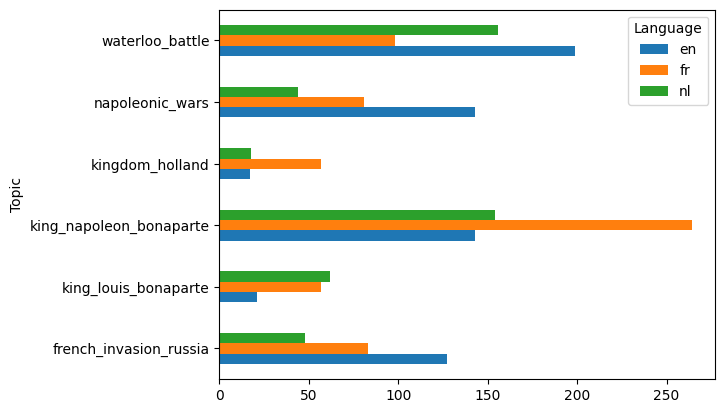

In [29]:
df.groupby(['Topic', 'Language']).value_counts().unstack().plot.barh()